Classification with CIFAR-10

In [1]:
#imports and environment
import optuna
from mpl_toolkits.axes_grid1 import ImageGrid
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10
import os
from torchvision import datasets, transforms
from MyModel import MyModel
from optuna.integration import PyTorchLightningPruningCallback
from torch.nn import functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import matplotlib.image as mpimg
from pathlib import Path
from MyCNN import MyCNN

Path("./outputs").mkdir(parents=True, exist_ok=True)
matplotlib.style.use('ggplot')

In [2]:
#data, dataloader
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                                ])

BATCH_SIZE = 1500

# data
cifar10_train = CIFAR10(os.getcwd(), train=True, download=True, transform=transform)
cifar10_test = CIFAR10(os.getcwd(), train=False, download=True, transform=transform)

# split train into train and validation
cifar10_train, cifar10_val = random_split(cifar10_train, [45000, 5000])

# dataloaders
cifar10_train = DataLoader(cifar10_train, batch_size=BATCH_SIZE)
cifar10_val = DataLoader(cifar10_val, batch_size=BATCH_SIZE)
cifar10_test = DataLoader(cifar10_test, batch_size=BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# optuna look for a good learning rate
def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    model = MyModel(lr)
    trainer = Trainer(gpus=1, max_epochs=10, callbacks=[EarlyStopping(monitor='val_loss')])
    trainer.fit(model, train_dataloader=cifar10_train, val_dataloaders=cifar10_val)
    losses = []
    for batch in cifar10_val:
        x, y = batch
        logits = model.forward(x)
        loss = F.cross_entropy(logits, y)
        losses.append(loss.cpu().detach().numpy())
    losses = np.asarray(losses)
    loss = np.mean(losses)
    return loss

In [6]:
# fit simple NN with Linear Layers
def run_linear():
    model = MyModel(1e-5)
    trainer = Trainer(gpus=1, max_epochs=200, callbacks=[EarlyStopping(monitor='val_loss')])
    trainer.fit(model, train_dataloader=cifar10_train, val_dataloaders=cifar10_val)
    trainer.save_checkpoint("example.ckpt")

# fit CNN
def run_cnn():
    model = MyCNN(1e-4)
    trainer = Trainer(gpus=1, max_epochs=200, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])
    trainer.fit(model, train_dataloader=cifar10_train, val_dataloaders=cifar10_val)
    trainer.save_checkpoint("example.ckpt")

# load
def load_model(path, lr):
    return MyCNN.load_from_checkpoint(
        checkpoint_path=path,
        lr=lr)


def plot_predictions():
    new_model = load_model("D:/Uni/TUM/Master Informatik/WS20/projects/classification/lightning_logs/version_183"
                        "/checkpoints/epoch=77-step=3431.ckpt", 1e-4)
    first_batch = next(iter(cifar10_val))
    logits = new_model.forward(first_batch[0])
    predictions = torch.argmax(logits, dim=1)
    labels = first_batch[1]
    first_batch = first_batch[0]
    label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    images = []
    fig = matplotlib.pyplot.figure()
    fig.set_size_inches(18.5, 10.5)
    for i in range(0, 25):
        plt.axis('off')
        plt.imshow(first_batch[i].permute(1, 2, 0))
        if predictions[i] == labels[i]:
            plt.title(label_names[predictions[i]], fontdict={'color': 'green', 'fontsize': 60})
        else:
            plt.title(label_names[predictions[i]], fontdict={'color': 'red', 'fontsize': 60})
        plt.savefig(f"./outputs/{i}.png")
        img = mpimg.imread(f"./outputs/{i}.png")
        images.append(img)
        # plt.show()
    plt.title("Predictions", fontdict={'color': 'black', 'fontsize': 20})
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(5, 5),  # creates 3x3 grid of axes
                     axes_pad=0.,  # pad between axes in inch.
                     )
    for ax, im in zip(grid, images):
        # Iterating over the grid returns the Axes.
        ax.grid(False)
        ax.axis('off')
        plt.axis('off')
        ax.imshow(im)
    plt.savefig(f"./outputs/predictions.png")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

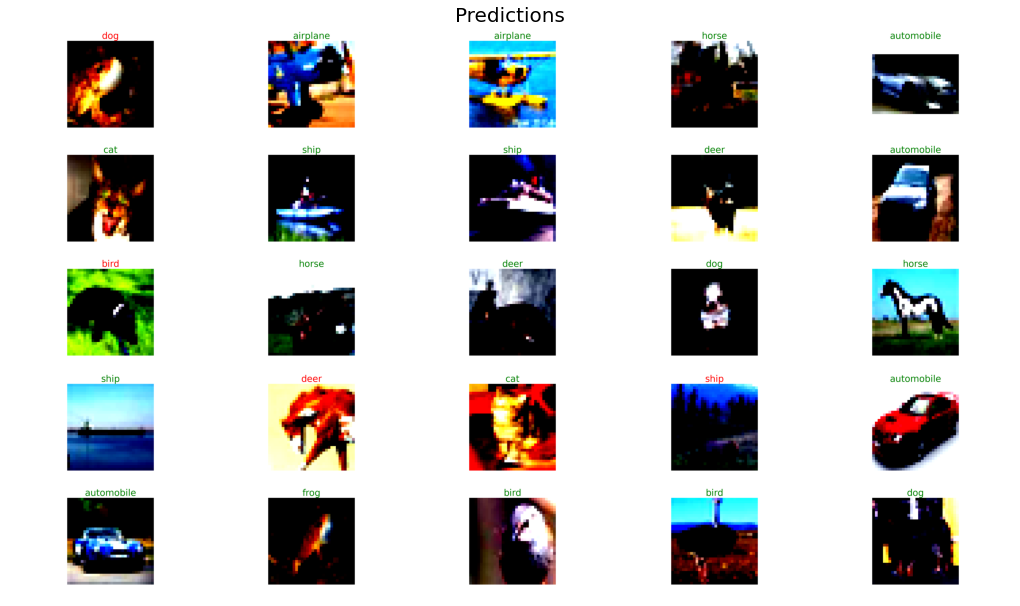

In [7]:
plot_predictions()